In [1]:
#finding the best number of test_size and trainning_data along with the n_estimators. Also comparing this data set with random chice data


#importing useful python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix#,confusion_matrix_at_thresholds


In [2]:
#loading dataset
df = pd.read_parquet("subset of baseline with samples 50neg & pos.parquet")

In [3]:
#stepping forward with useful numerical data only
X = df.drop(columns=['object','cluster', 'cluster_id']).values

In [4]:
# object column contains names like 'ZTF18abc...' or non-ZTF names : Binary conversion of objects
y = np.where(df['object'].str.contains('ZTF',case=False), #case=False accounts to take every form of ztf,ZTF etc
             -1,   # ZTF → negative
              1)   # non-ZTF → positive

In [5]:

#now we'll run a step-by-step code to implement most accurate number os trees in my random(n_estimator value) and test train split(test_size)
train_sizes = np.arange(0.5, 0.91, 0.01)          # 50% to 90% test_size
n_estimators_list = np.arange(10, 151, 10)         # 10 to 150 trees


In [6]:
results = []

for size_train in train_sizes:

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        train_size=size_train,
        shuffle=True,
    )
#generating random array
    
    y_random = np.random.choice(
        np.unique(y),
        size=len(y_test),
        replace=True
    )
    random_acc = accuracy_score(y_test, y_random)

    for n in n_estimators_list:

        # Random Forest fitting
        clf = RandomForestClassifier(
            n_estimators=n,
            class_weight="balanced",  
            n_jobs=-1
        )

        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        rf_acc = accuracy_score(y_test, y_pred)

        # saved results
        results.append({
            "n_estimators": n,
            "size_train": size_train,
            "random_acc": random_acc,
            "rf_acc": rf_acc
        })


In [7]:
df = pd.DataFrame(results)
df.head()

,n_estimators,size_train,random_acc,rf_acc
0,10,0.5,0.57,0.9475
1,20,0.5,0.57,0.9425
2,30,0.5,0.57,0.9525
3,40,0.5,0.57,0.9475
4,50,0.5,0.57,0.9525


In [8]:
best_row = df.loc[df["rf_acc"].idxmax()]

best_train_size = best_row["size_train"]
best_n_estimators = best_row["n_estimators"]
best_accuracy = best_row["rf_acc"]

print("Best configuration:")
print(f"Train size      : {best_train_size}")
print(f"n_estimators    : {best_n_estimators}")
print(f"Test accuracy   : {best_accuracy:.4f}")


Best configuration:
Train size      : 0.8900000000000003
n_estimators    : 30.0
Test accuracy   : 1.0000


In [9]:
df.to_csv("random_forest_results_1.csv")
print('saved')


saved


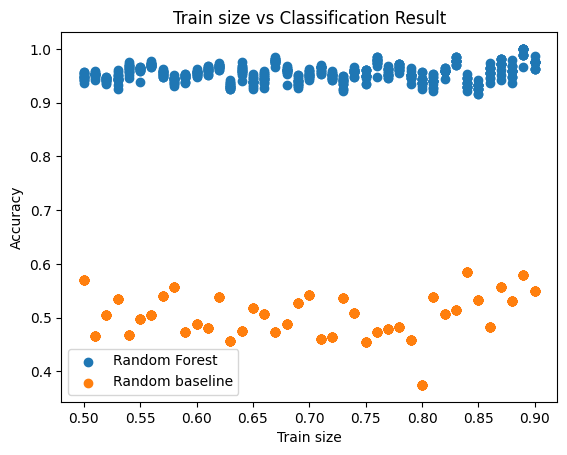

In [10]:
# Ensure 1D numeric arrays
x_train_size = df['size_train'].to_numpy()
rf_acc = df['rf_acc'].to_numpy()
y_random = df['random_acc'].to_numpy()  
#X-axis: train size, Y-axis: classification results
# Plot
plt.figure()
plt.scatter(x_train_size, rf_acc, marker='o', label='Random Forest')
plt.scatter(x_train_size, y_random, marker='o', label='Random baseline')
plt.xlabel('Train size')
plt.ylabel('Accuracy')
plt.title('Train size vs Classification Result')
plt.legend()
plt.show()


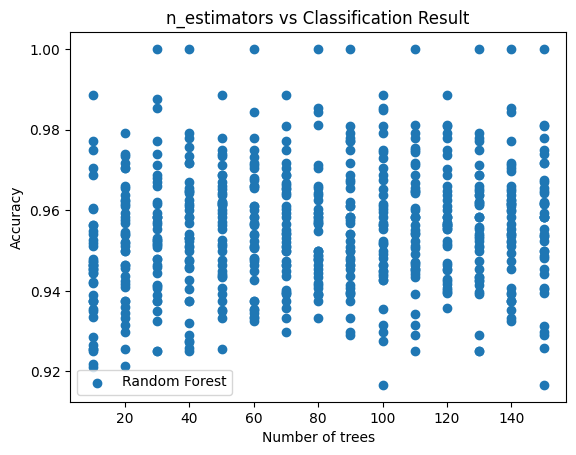

In [11]:
#X-axis: n_estimators, Y-axis: classification results
x_n_estimators = df['n_estimators'].to_numpy()

plt.figure()
plt.scatter(x_n_estimators,rf_acc, marker='o', label='Random Forest')
#plt.plot(x_n_estimators,y_random, marker='o', label='Random baseline')
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.title('n_estimators vs Classification Result')
plt.legend()
plt.show()


In [12]:
#run accuracy
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,  #ml has tendency to take larger data for training and less of test,as it gave best train size ~90% went with 80~20 proportion
)

final_model = RandomForestClassifier(
    n_estimators=30,
    class_weight="balanced",
   
)

final_model.fit(X_train, y_train)

test_accuracy = final_model.score(X_test, y_test)
print("\nFinal test accuracy:", test_accuracy)



Final test accuracy: 0.95625


Confusion matrix (raw counts):
[[139   3]
 [  4  14]]


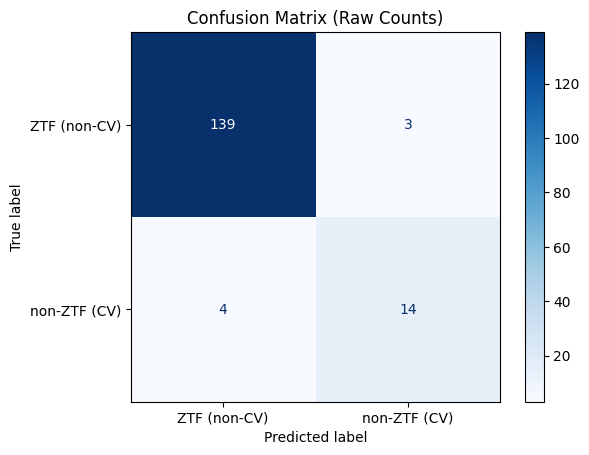

In [13]:
# CONFUSION MATRIX + TP / TN / FP / FN IDENTIFICATION
# Class labels for clarity
class_names = ["ZTF (non-CV)", "non-ZTF (CV)"]

# Plot confusion matrix (raw counts)
disp = ConfusionMatrixDisplay.from_estimator(
   final_model,
    X_test,
    y_test,
    display_labels=class_names,
    cmap=plt.cm.Blues #heatmap
)

disp.ax_.set_title("Confusion Matrix (Raw Counts)")
print("Confusion matrix (raw counts):")
print(disp.confusion_matrix)

plt.show()


# Extract TN, FP, FN, TP explicitly
# Label convention used in YOUR code:
#   -1 → ZTF (negative, non-CV)
#   +1 → non-ZTF (positive, CV)

cm = confusion_matrix(y_test, clf.predict(X_test), labels=[-1, 1])

TN, FP, FN, TP = cm.ravel()


